In [30]:
!pip install tensorflow  opencv-python mediapipe sklearn matplotlib pillow

In [40]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from PIL import Image, ImageDraw, ImageFont

mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

#load train model 
from tensorflow.keras.models import load_model

In [41]:
# actions = np.array(['අ', 'ආ', 'ඇ','ඈ','ඉ','ඊ','උ','ඌ','එ','ඒ','ඔ','ඕ','ක්','ග්','ජ්','ට්','ද්','ණ්','ත්','ඩ්','න්','ප්','බ්','ම්','ය්','ර්','ල්','ව්','ස්','හ්'])
actions = np.array(['අ', 'ආ', 'ඇ','ඈ','ඉ','ඊ','උ','ඌ','එ','ඒ'])		
#actions = np.array(['ඊ','උ','ඌ','එ','ඒ'])
# actions = np.array(['අ', 'ආ', 'ඇ','ඈ','ඉ'])	
# Thirty videos worth of data
no_sequences = 30
# Each One Video  going to be 30 frames in length
sequence_length = 30
# Folder start
start_folder = 0

In [42]:
model = load_model('action.keras')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 30, 64)            48896     
                                                                 
 lstm_19 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_20 (LSTM)              (None, 64)                49408     
                                                                 
 dense_18 (Dense)            (None, 64)                4160      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 10)                330       
                                                                 
Total params: 203690 (795.66 KB)
Trainable params: 203

In [43]:
colors = [(245, 117, 16), (117, 245, 16), (16, 117, 245), (16, 245, 117), (245, 16, 117),
          (117, 16, 245), (245, 245, 16), (16, 245, 245), (245, 16, 245), (16, 16, 245),
          (117, 16, 16), (16, 117, 117), (245, 245, 117), (117, 245, 245), (245, 117, 245),
          (245, 245, 245), (117, 117, 16), (16, 117, 117), (117, 16, 117), (117, 117, 245),
          (245, 117, 117), (117, 245, 117), (117, 117, 117), (16, 16, 117), (16, 117, 16),
          (245, 16, 16), (16, 245, 16), (16, 16, 16), (245, 245, 16), (245, 245, 19)]
font = ImageFont.truetype("D:\Research\sinahlaFont.ttf", 15)
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
         # Convert  Numpy array and switch  from BGR to RGB
        image = cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image)
        draw = ImageDraw.Draw(pil_image)
        #dynamic_text = actions[num];
        dynamic_text = actions[num];
           # Calculate the text position
        text_x = 10   # Adjust the starting position of the text
        text_y = 65 + num * 40
        draw.text((text_x, text_y), dynamic_text, font=font, fill=(255, 255, 255))  
        print("actions",actions)
                        
        # Convert back to Numpy array and switch back from RGB to BGR
        converted_image = np.asarray(pil_image)
        output_frame = cv2.cvtColor(converted_image, cv2.COLOR_RGB2BGR)
   
        
    return output_frame

actions ['අ' 'ආ' 'ඇ' 'ඈ' 'ඉ' 'ඊ' 'උ' 'ඌ' 'එ' 'ඒ']
actions ['අ' 'ආ' 'ඇ' 'ඈ' 'ඉ' 'ඊ' 'උ' 'ඌ' 'එ' 'ඒ']
actions ['අ' 'ආ' 'ඇ' 'ඈ' 'ඉ' 'ඊ' 'උ' 'ඌ' 'එ' 'ඒ']
actions ['අ' 'ආ' 'ඇ' 'ඈ' 'ඉ' 'ඊ' 'උ' 'ඌ' 'එ' 'ඒ']
actions ['අ' 'ආ' 'ඇ' 'ඈ' 'ඉ' 'ඊ' 'උ' 'ඌ' 'එ' 'ඒ']


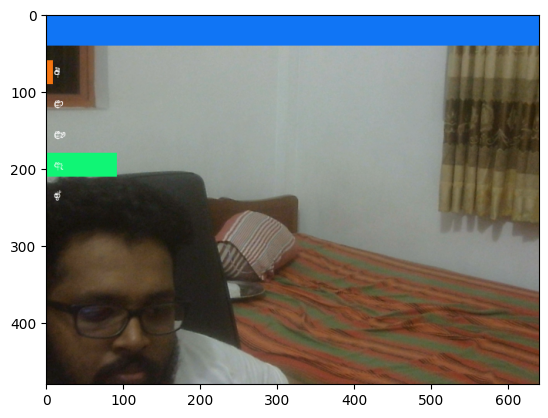

In [44]:
plt.imshow(prob_viz(res,actions,image,colors))

In [45]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    print( "left",results.left_hand_landmarks)
    print( "right",results.right_hand_landmarks)
    return image, results

In [46]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [47]:
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [48]:
def draw_styled_landmarks(image, results):
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.5
font = ImageFont.truetype("D:\Research\sinahlaFont.ttf", 15)
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.4, min_tracking_confidence=0.4) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print("Predictions:", res)
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
             # Convert  Numpy array and switch  from BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image)
        draw = ImageDraw.Draw(pil_image)
        dynamic_text = ' '.join(sentence);
        draw.text((10, 10),dynamic_text, font=font)
    
                        
        # Convert back to Numpy array and switch back from RGB to BGR
        converted_image = np.asarray(pil_image)
        cv2image = cv2.cvtColor(converted_image, cv2.COLOR_RGB2BGR)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', cv2image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [21]:
cap.release()
cv2.destroyAllWindows()